100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


(100000, 6)
                timestamp      open      high       low     close   volume
99995 2025-01-02 05:23:56  95661.92  95661.93  95661.92  95661.93  0.00414
99996 2025-01-02 05:23:57  95661.93  95661.93  95661.93  95661.93  0.00000
99997 2025-01-02 05:23:58  95661.92  95661.93  95661.92  95661.93  0.00289
99998 2025-01-02 05:23:59  95661.93  95661.93  95661.92  95661.92  0.00639
99999 2025-01-02 05:24:00  95661.93  95661.93  95661.93  95661.93  0.01337


Running backtests: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


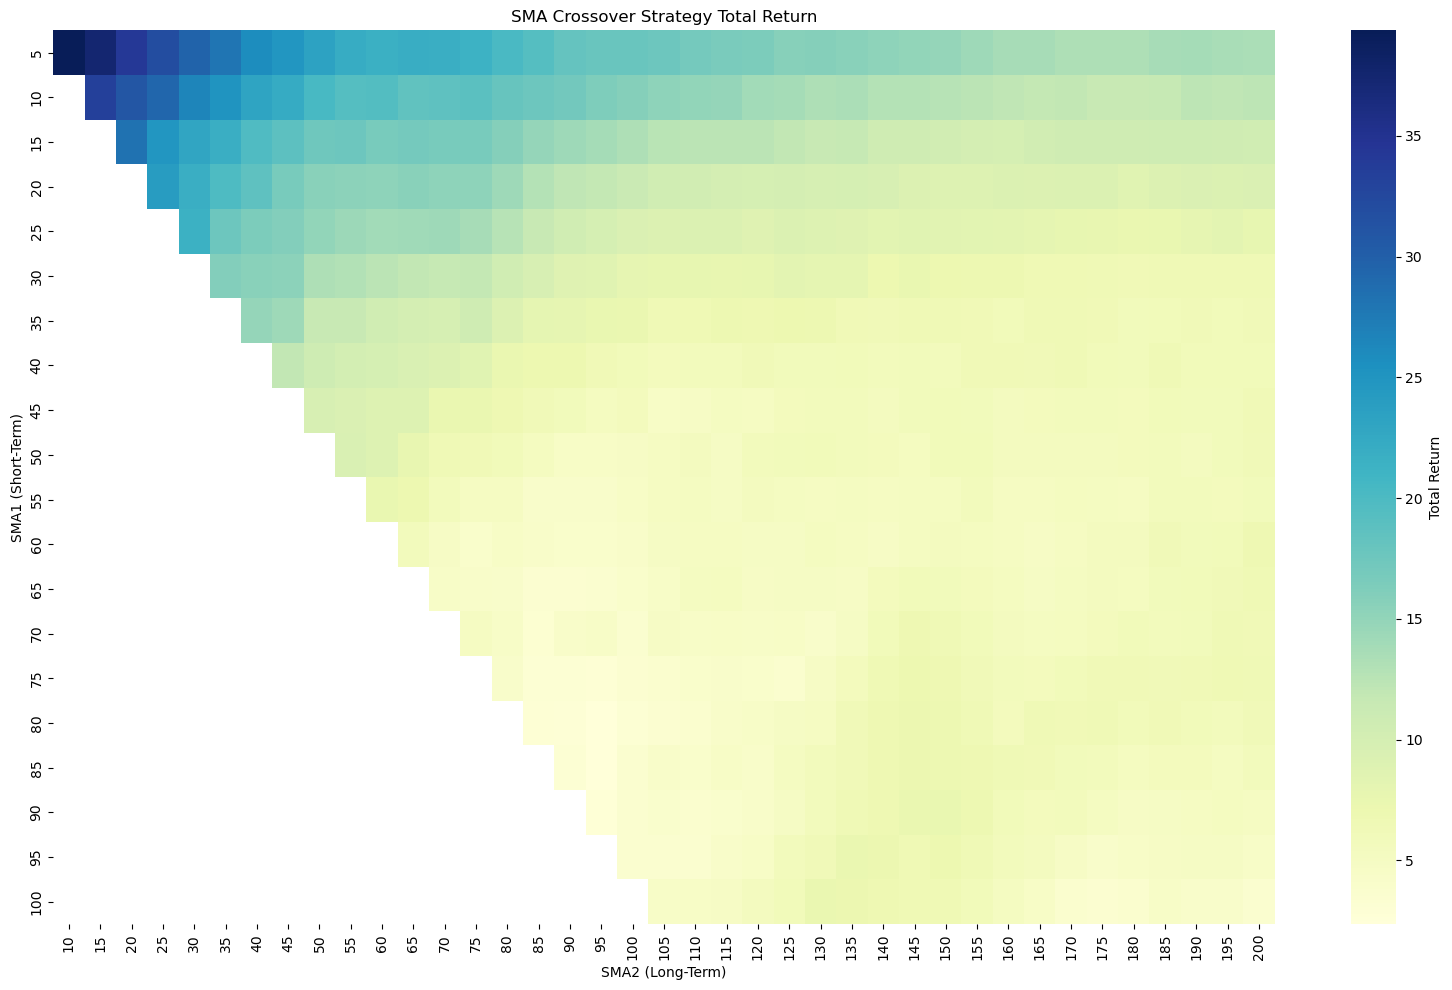

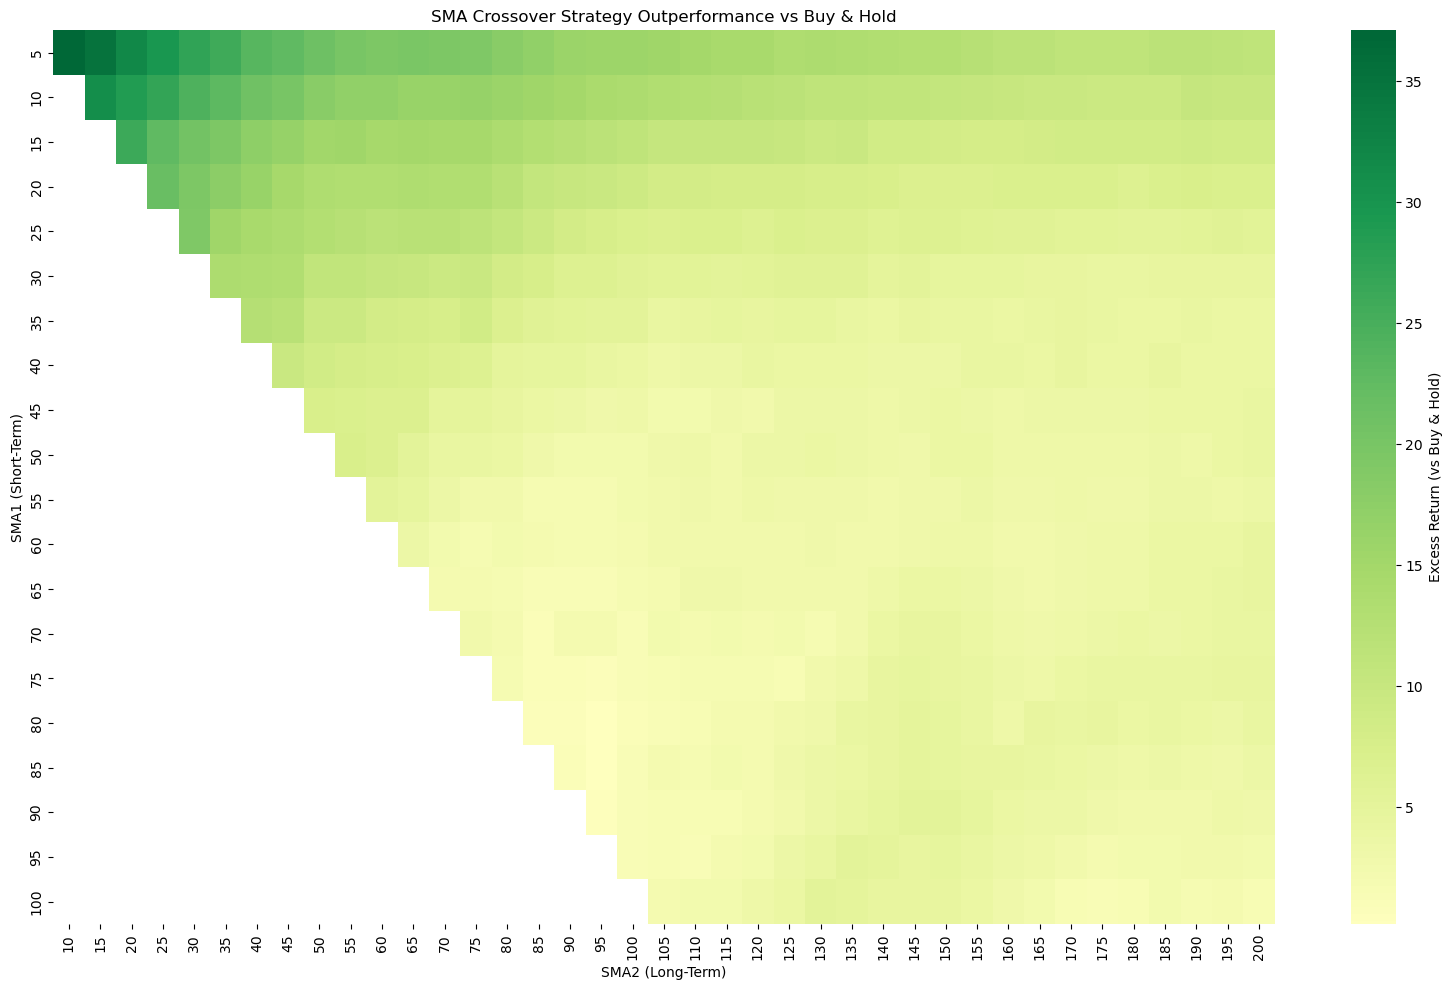

最佳雙均線參數: n1=5, n2=10
最佳策略報酬率: 39.37%
大盤報酬率: 2.26%


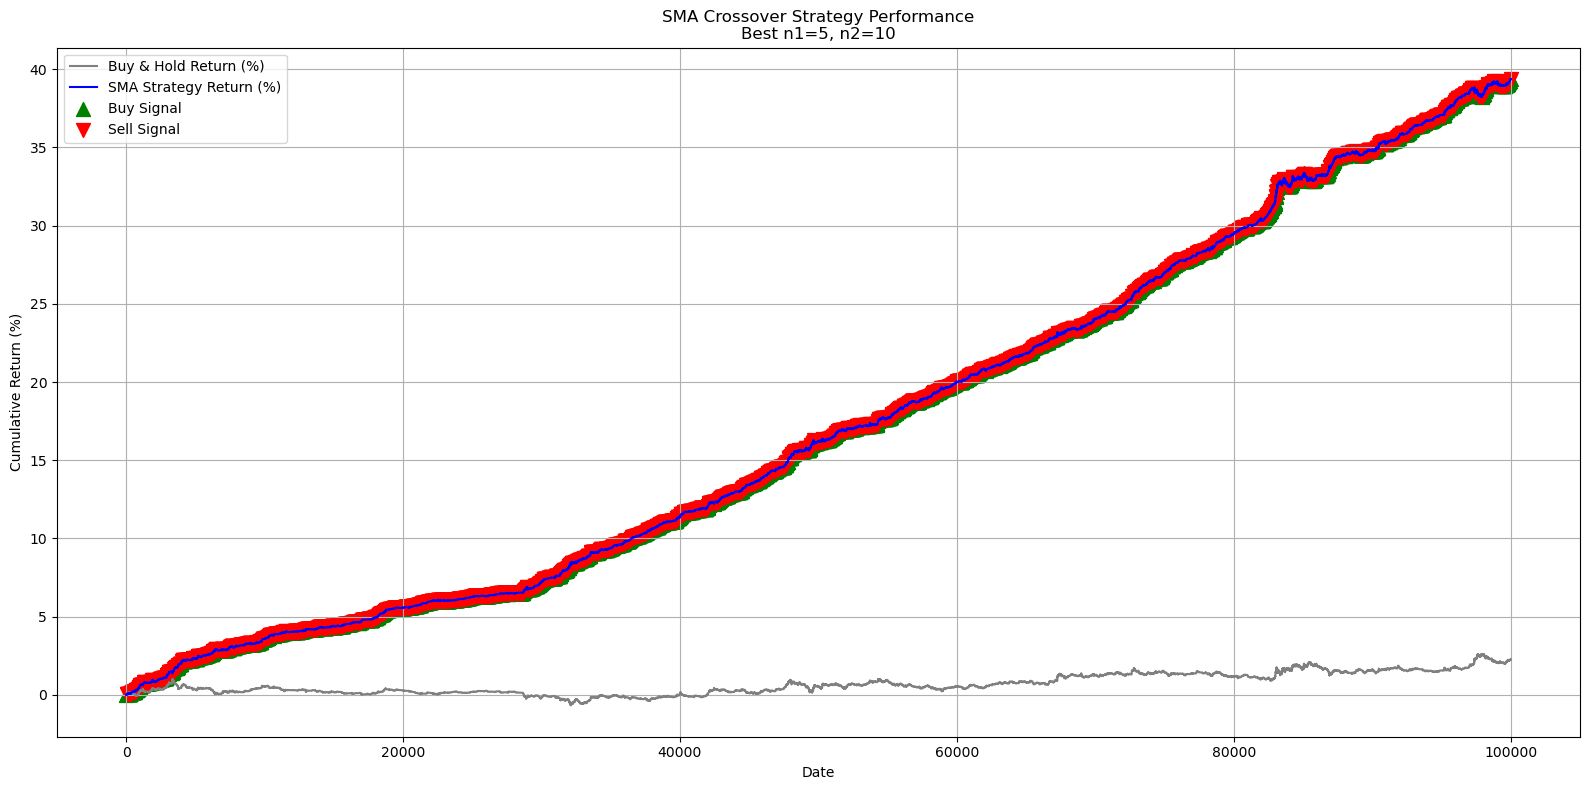

In [234]:
import ccxt
import pandas as pd
import time
from tqdm import tqdm

binance = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1s'
limit_per_call = 1000
total_limit = 100000

all_ohlcv = []
since = binance.parse8601('2025-01-01T00:00:00Z')  # 起始時間（可自定）

for _ in tqdm(range(total_limit // limit_per_call)):
    ohlcv = binance.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit_per_call)
    if not ohlcv:
        break
    all_ohlcv.extend(ohlcv)
    since = ohlcv[-1][0] + 60_000  # 下一次從上次的最後一筆 + 1 分鐘
    time.sleep(0.5)  # 加入延遲避免被 API 限速（重要）

# 轉成 DataFrame
df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
print(df.shape)

# 顯示結果
print(df.tail())

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SMA 交叉策略回測函數
def backtest_sma_strategy(df, n1, n2):
    if n1 >= n2:
        return np.nan, np.nan  # ✅ 一律回傳 tuple

    data = df.copy()
    data['sma1'] = data['close'].rolling(n1).mean()
    data['sma2'] = data['close'].rolling(n2).mean()
    data.dropna(inplace=True)

    # 訊號與持倉
    data['signal'] = 0
    data.loc[(data['sma1'] > data['sma2']) & (data['sma1'].shift(1) <= data['sma2'].shift(1)), 'signal'] = 1
    data.loc[(data['sma1'] < data['sma2']) & (data['sma1'].shift(1) >= data['sma2'].shift(1)), 'signal'] = -1
    data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)

    # 報酬率計算
    data['returns'] = np.log(data['close'] / data['close'].shift(1))
    data['strategy'] = data['position'].shift(1) * data['returns']

    # 策略與大盤的總報酬率
    strategy_return = np.exp(data['strategy'].sum()) - 1
    buy_hold_return = np.exp(data['returns'].sum()) - 1

    return strategy_return*100, buy_hold_return*100

n1_range = range(5, 105, 5)
n2_range = range(10, 205, 5)

heatmap_strategy = pd.DataFrame(index=n1_range, columns=n2_range)
heatmap_outperformance = pd.DataFrame(index=n1_range, columns=n2_range)

# 任選一組計算大盤報酬率
sample_return = np.exp(np.log(df['close'] / df['close'].shift(1)).dropna().sum()) - 1

for n1 in tqdm(n1_range, desc="Running backtests"):
    for n2 in n2_range:
        result = backtest_sma_strategy(df, n1, n2)
        if result is None or np.isnan(result[0]):
            continue
        strategy_ret, buy_hold_ret = result
        heatmap_strategy.loc[n1, n2] = strategy_ret
        heatmap_outperformance.loc[n1, n2] = strategy_ret - buy_hold_ret


plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_strategy.astype(float), cmap="YlGnBu", annot=False, cbar_kws={'label': 'Total Return'})
plt.title("SMA Crossover Strategy Total Return")
plt.xlabel("SMA2 (Long-Term)")
plt.ylabel("SMA1 (Short-Term)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_outperformance.astype(float), cmap="RdYlGn", center=0, annot=False,
            cbar_kws={'label': 'Excess Return (vs Buy & Hold)'})
plt.title("SMA Crossover Strategy Outperformance vs Buy & Hold")
plt.xlabel("SMA2 (Long-Term)")
plt.ylabel("SMA1 (Short-Term)")
plt.tight_layout()
plt.show()

# 找出最佳策略組合 (最大策略報酬)
stacked = heatmap_strategy.astype(float).stack()
best_n1, best_n2 = stacked.idxmax()

print(f"最佳雙均線參數: n1={best_n1}, n2={best_n2}")
print(f"最佳策略報酬率: {stacked.max():.2f}%")
print(f"大盤報酬率: {(-heatmap_outperformance.loc[best_n1, best_n2] + heatmap_strategy.loc[best_n1, best_n2]):.2f}%")

# 取最佳參數計算訊號及報酬率曲線
data = df.copy()
data['sma1'] = data['close'].rolling(best_n1).mean()
data['sma2'] = data['close'].rolling(best_n2).mean()
data.dropna(inplace=True)

# 產生買賣訊號
data['signal'] = 0
data.loc[(data['sma1'] > data['sma2']) & (data['sma1'].shift(1) <= data['sma2'].shift(1)), 'signal'] = 1
data.loc[(data['sma1'] < data['sma2']) & (data['sma1'].shift(1) >= data['sma2'].shift(1)), 'signal'] = -1
data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)

# 計算報酬率與累積報酬率
data['returns'] = np.log(data['close'] / data['close'].shift(1))
data['strategy_returns'] = data['position'].shift(1) * data['returns']

data['cum_strategy_returns'] = np.exp(data['strategy_returns'].cumsum()) - 1
data['cum_buy_hold_returns'] = np.exp(data['returns'].cumsum()) - 1

# 畫圖
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['cum_buy_hold_returns']*100, label='Buy & Hold Return (%)', color='gray')
plt.plot(data.index, data['cum_strategy_returns']*100, label='SMA Strategy Return (%)', color='blue')

# 標記買點(黃金交叉)
buy_signals = data[data['signal'] == 1]
plt.scatter(buy_signals.index, data.loc[buy_signals.index, 'cum_strategy_returns']*100,
            marker='^', color='green', label='Buy Signal', s=100)

# 標記賣點(死亡交叉)
sell_signals = data[data['signal'] == -1]
plt.scatter(sell_signals.index, data.loc[sell_signals.index, 'cum_strategy_returns']*100,
            marker='v', color='red', label='Sell Signal', s=100)

plt.title(f"SMA Crossover Strategy Performance\nBest n1={best_n1}, n2={best_n2}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 目前這整套pipeline可能只是看到一個過擬合的結果 請切一份最終測試集
# 在上面跑最佳n1,n2跑出來的報酬率曲線


Running backtests (train): 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]

最佳雙均線參數(訓練集): n1=5, n2=10
訓練集最佳策略報酬率: 29.46%


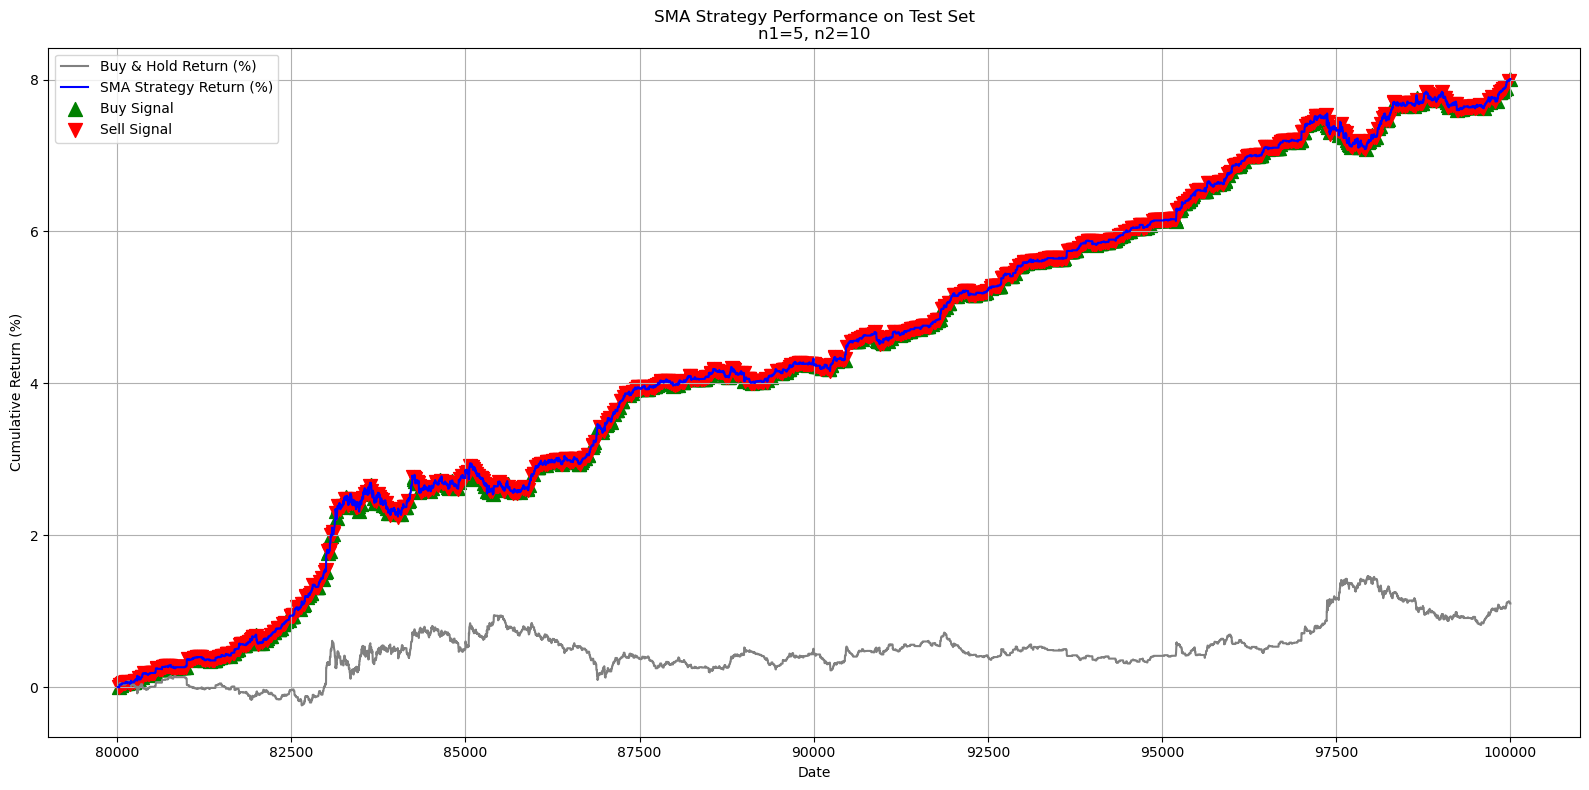

In [235]:
# 以時間切分：80% 訓練，20% 測試（依時間序列）
split_idx = int(len(df)*0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 用訓練集跑回測找最佳參數
heatmap_strategy = pd.DataFrame(index=n1_range, columns=n2_range)
heatmap_outperformance = pd.DataFrame(index=n1_range, columns=n2_range)

for n1 in tqdm(n1_range, desc="Running backtests (train)"):
    for n2 in n2_range:
        strategy_ret, buy_hold_ret = backtest_sma_strategy(train_df, n1, n2)
        if np.isnan(strategy_ret):
            continue
        heatmap_strategy.loc[n1, n2] = strategy_ret
        heatmap_outperformance.loc[n1, n2] = strategy_ret - buy_hold_ret

stacked = heatmap_strategy.astype(float).stack()
best_n1, best_n2 = stacked.idxmax()
print(f"最佳雙均線參數(訓練集): n1={best_n1}, n2={best_n2}")
print(f"訓練集最佳策略報酬率: {stacked.max():.2f}%")

# 用測試集跑最佳參數回測，畫出報酬率曲線和買賣點
def plot_strategy_performance(df, n1, n2):
    data = df.copy()
    data['sma1'] = data['close'].rolling(n1).mean()
    data['sma2'] = data['close'].rolling(n2).mean()
    data.dropna(inplace=True)

    data['signal'] = 0
    data.loc[(data['sma1'] > data['sma2']) & (data['sma1'].shift(1) <= data['sma2'].shift(1)), 'signal'] = 1
    data.loc[(data['sma1'] < data['sma2']) & (data['sma1'].shift(1) >= data['sma2'].shift(1)), 'signal'] = -1
    data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)

    data['returns'] = np.log(data['close'] / data['close'].shift(1))
    data['strategy_returns'] = data['position'].shift(1) * data['returns']
    data['cum_strategy_returns'] = np.exp(data['strategy_returns'].cumsum()) - 1
    data['cum_buy_hold_returns'] = np.exp(data['returns'].cumsum()) - 1

    plt.figure(figsize=(16, 8))
    plt.plot(data.index, data['cum_buy_hold_returns']*100, label='Buy & Hold Return (%)', color='gray')
    plt.plot(data.index, data['cum_strategy_returns']*100, label='SMA Strategy Return (%)', color='blue')

    buy_signals = data[data['signal'] == 1]
    plt.scatter(buy_signals.index, data.loc[buy_signals.index, 'cum_strategy_returns']*100,
                marker='^', color='green', label='Buy Signal', s=100)

    sell_signals = data[data['signal'] == -1]
    plt.scatter(sell_signals.index, data.loc[sell_signals.index, 'cum_strategy_returns']*100,
                marker='v', color='red', label='Sell Signal', s=100)

    plt.title(f"SMA Strategy Performance on Test Set\nn1={n1}, n2={n2}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_strategy_performance(test_df, best_n1, best_n2)

# 做一個考量到交易手續費的版本以幣安比特幣手續費為例，每筆交易為0.1%


Running backtests with fee (train): 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]

最佳雙均線參數(含手續費): n1=5, n2=10
訓練集最佳策略報酬率(含手續費): 29.46%
✅ 交易統計結果:
總交易筆數: 4231
期間總天數: 0 天
平均每天交易次數: nan
平均每小時交易次數: nan
平均每筆交易報酬（含手續費）: -0.0236%


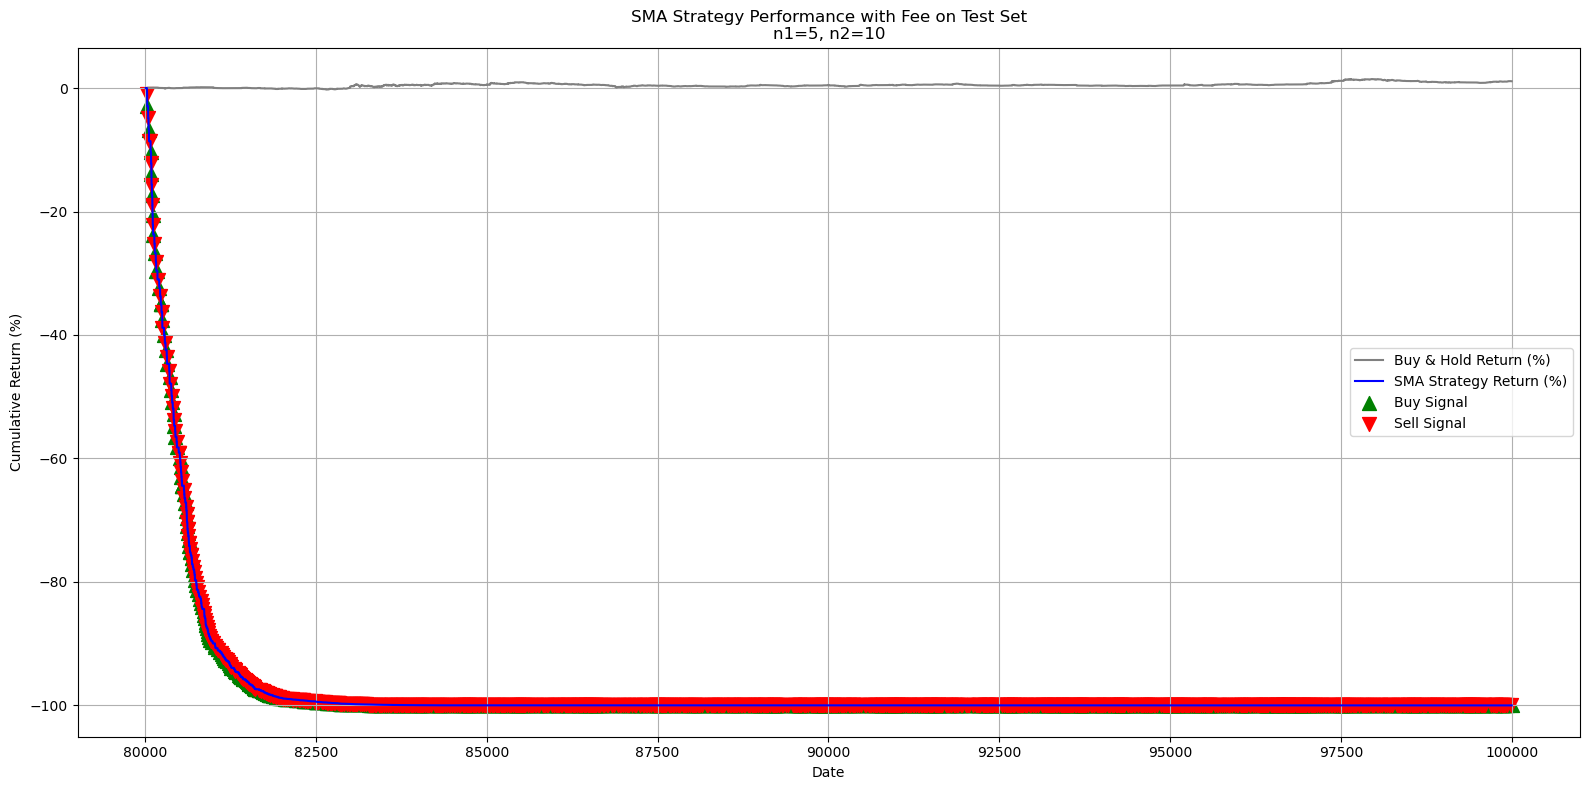

In [240]:
def backtest_sma_strategy_with_fee(df, n1, n2, fee=0.00):
    if n1 >= n2:
        return np.nan, np.nan

    data = df.copy()
    data['sma1'] = data['close'].rolling(n1).mean()
    data['sma2'] = data['close'].rolling(n2).mean()
    data.dropna(inplace=True)

    data['signal'] = 0
    data.loc[(data['sma1'] > data['sma2']) & (data['sma1'].shift(1) <= data['sma2'].shift(1)), 'signal'] = 1
    data.loc[(data['sma1'] < data['sma2']) & (data['sma1'].shift(1) >= data['sma2'].shift(1)), 'signal'] = -1
    data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)

    data['returns'] = np.log(data['close'] / data['close'].shift(1))

    # 計算交易次數 (position 變動點)
    data['trade'] = data['position'].diff().abs()  # 變動幅度為 2（-1到1），或 1（0到1/-1）
    # 交易發生位置 trade>0，對應扣手續費 (費用以 log return 表示： ln(1 - fee) ≈ -fee)
    # 用 log return 表示手續費扣除
    fee_log = np.log(1 - fee)

    # 策略報酬：持倉日報酬 + 交易日扣除手續費
    data['strategy'] = data['position'].shift(1) * data['returns'] + data['trade'] * fee_log

    strategy_return = np.exp(data['strategy'].sum()) - 1
    buy_hold_return = np.exp(data['returns'].sum()) - 1

    return strategy_return*100, buy_hold_return*100

# 範例：用訓練集跑熱力圖（加入手續費）
heatmap_strategy_fee = pd.DataFrame(index=n1_range, columns=n2_range)
heatmap_outperformance_fee = pd.DataFrame(index=n1_range, columns=n2_range)

for n1 in tqdm(n1_range, desc="Running backtests with fee (train)"):
    for n2 in n2_range:
        strategy_ret, buy_hold_ret = backtest_sma_strategy_with_fee(train_df, n1, n2, fee=0.00)
        if np.isnan(strategy_ret):
            continue
        heatmap_strategy_fee.loc[n1, n2] = strategy_ret
        heatmap_outperformance_fee.loc[n1, n2] = strategy_ret - buy_hold_ret

stacked_fee = heatmap_strategy_fee.astype(float).stack()
best_n1_fee, best_n2_fee = stacked_fee.idxmax()
print(f"最佳雙均線參數(含手續費): n1={best_n1_fee}, n2={best_n2_fee}")
print(f"訓練集最佳策略報酬率(含手續費): {stacked_fee.max():.2f}%")

# 畫含手續費的策略績效曲線（測試集）
def plot_strategy_performance_with_fee(df, n1, n2, fee=0.0):
    data = df.copy()
    data['sma1'] = data['close'].rolling(n1).mean()
    data['sma2'] = data['close'].rolling(n2).mean()
    data.dropna(inplace=True)

    data['signal'] = 0
    data.loc[(data['sma1'] > data['sma2']) & (data['sma1'].shift(1) <= data['sma2'].shift(1)), 'signal'] = 1
    data.loc[(data['sma1'] < data['sma2']) & (data['sma1'].shift(1) >= data['sma2'].shift(1)), 'signal'] = -1
    data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)

    data['returns'] = np.log(data['close'] / data['close'].shift(1))
    data['trade'] = data['position'].diff().abs()
    fee_log = np.log(1 - fee)
    data['strategy_returns'] = data['position'].shift(1) * data['returns'] + data['trade'] * fee_log
    data['cum_strategy_returns'] = np.exp(data['strategy_returns'].cumsum()) - 1
    data['cum_buy_hold_returns'] = np.exp(data['returns'].cumsum()) - 1

    # 統計
    total_trades = int(data['trade'].sum())  # 交易次數（position 變化次數）
    total_days = (data['timestamp'].iloc[-1] - data['timestamp'].iloc[0]).days
    trade_per_day = total_trades / total_days if total_days > 0 else np.nan
    trade_per_hour = trade_per_day / 24
    avg_profit_per_trade = (np.exp(data['strategy_returns'].sum()) - 1) / total_trades if total_trades > 0 else np.nan

    print(f"✅ 交易統計結果:")
    print(f"總交易筆數: {total_trades}")
    print(f"期間總天數: {total_days} 天")
    print(f"平均每天交易次數: {trade_per_day:.4f}")
    print(f"平均每小時交易次數: {trade_per_hour:.6f}")
    print(f"平均每筆交易報酬（含手續費）: {avg_profit_per_trade*100:.4f}%")

    # 畫圖
    plt.figure(figsize=(16, 8))
    plt.plot(data.index, data['cum_buy_hold_returns']*100, label='Buy & Hold Return (%)', color='gray')
    plt.plot(data.index, data['cum_strategy_returns']*100, label='SMA Strategy Return (%)', color='blue')

    buy_signals = data[data['signal'] == 1]
    plt.scatter(buy_signals.index, data.loc[buy_signals.index, 'cum_strategy_returns']*100,
                marker='^', color='green', label='Buy Signal', s=100)

    sell_signals = data[data['signal'] == -1]
    plt.scatter(sell_signals.index, data.loc[sell_signals.index, 'cum_strategy_returns']*100,
                marker='v', color='red', label='Sell Signal', s=100)

    plt.title(f"SMA Strategy Performance with Fee on Test Set\nn1={n1}, n2={n2}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_strategy_performance_with_fee(test_df, best_n1_fee, best_n2_fee, fee=0.01)


✅ 交易統計結果:
總交易筆數: 4231
期間總天數: 0 天
平均每天交易次數: nan
平均每小時交易次數: nan
平均每筆交易報酬（含手續費）: 0.0019%


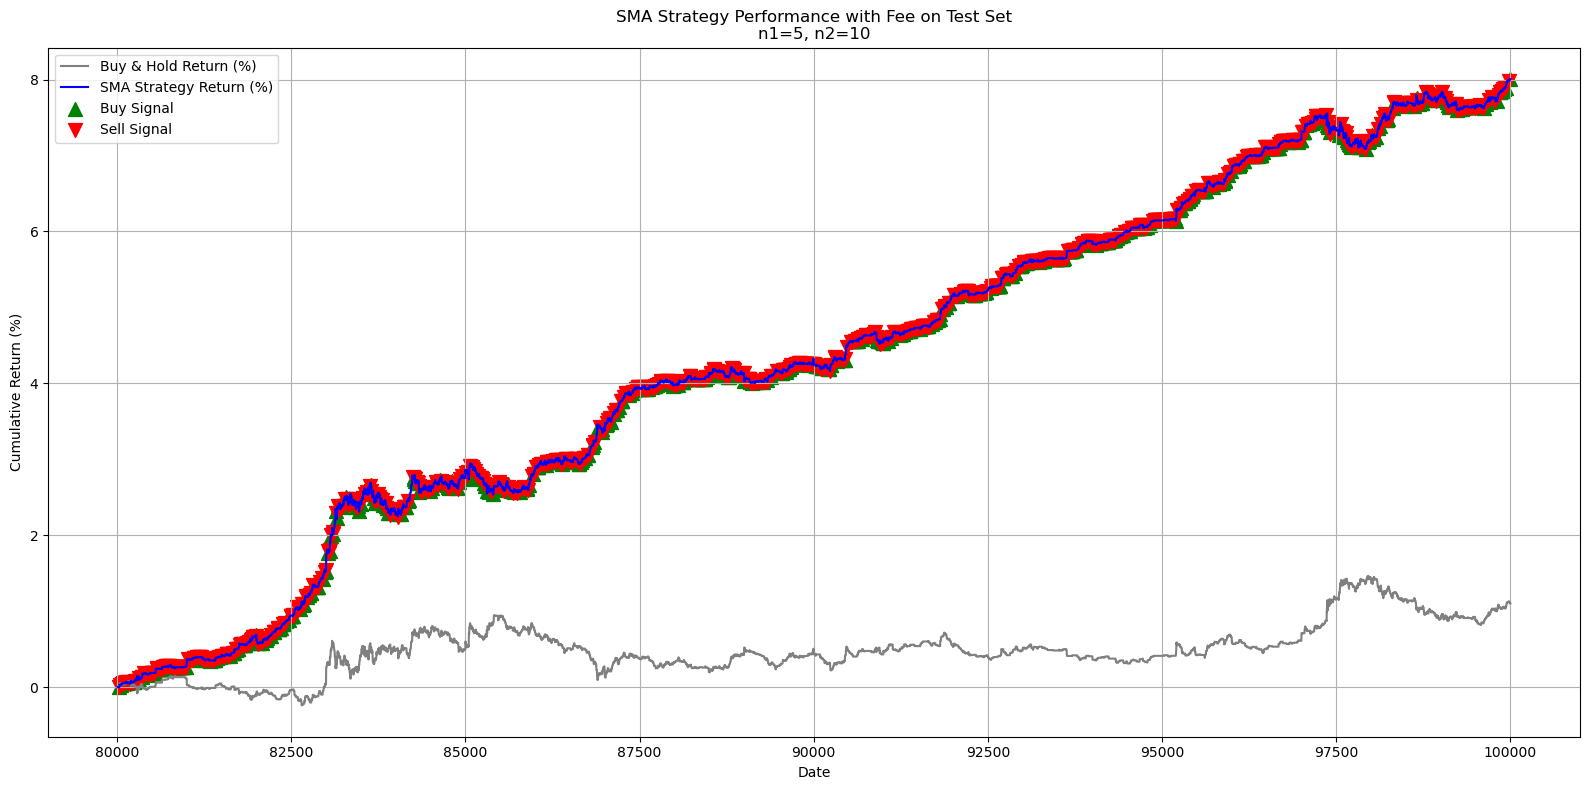

In [241]:
plot_strategy_performance_with_fee(test_df, best_n1_fee, best_n2_fee, fee=0.00)

✅ 交易統計結果:
總交易筆數: 4231
期間總天數: 0 天
平均每天交易次數: nan
平均每小時交易次數: nan
平均每筆交易報酬（含手續費）: -0.0236%


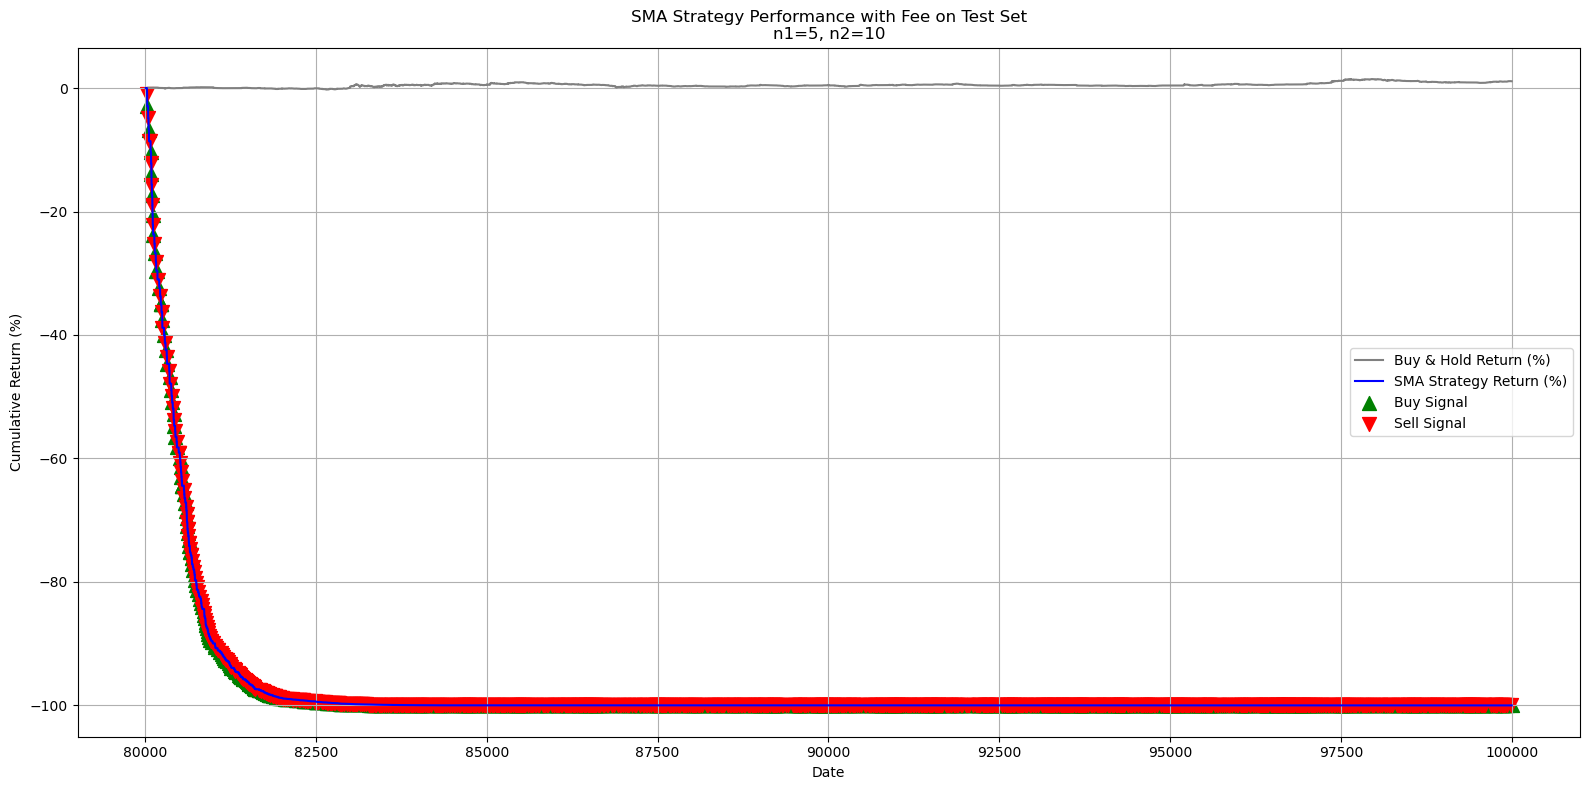

In [242]:
plot_strategy_performance_with_fee(test_df, best_n1_fee, best_n2_fee, fee=0.01)